In [1]:
%load_ext autoreload
%matplotlib inline

/Users/diego/.pyenv/versions/miniconda-latest/lib/python2.7/site-packages/subprocess32.py:472: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)


In [2]:
%autoreload 2

import torch
from torch.autograd import Variable
from torch import nn, optim
import torchvision.models
import numpy as np
import models, utils

### Load trained VGG Model

In [3]:
net = models.ModifiedVGG()

### Load Content Image

torch.Size([1, 3, 375, 500])

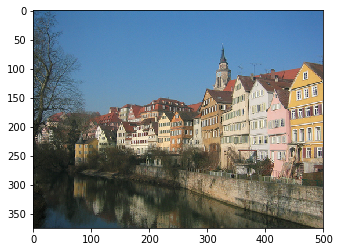

In [4]:
content_filename = 'tubingen.jpg'
content_arr = utils.load_image(content_filename, max_size=(500,500))
content_var = utils.image_to_var(content_arr).detach()
content_var.size()

### Load Style Image

torch.Size([1, 3, 375, 500])

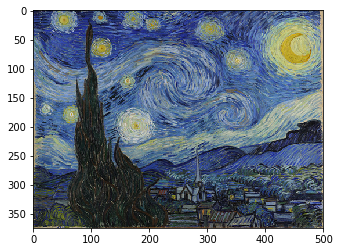

In [5]:
style_filename = 'starry-night.jpg'
style_arr = utils.load_image(style_filename, shape=reversed(content_arr.shape[:2]))
style_var = utils.image_to_var(style_arr).detach()
style_var.size()

In [6]:
style_layer_names = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
content_layer_names = ['conv4_1']

### Convert Style and Content images to Gram Matrix Representations

In [7]:
def gram_repr(image_var, net, layer_names):
    '''
    Return list with gram matrix representations of image_var
    '''
    # Obtain conv. layers output
    layers = net(image_var)[1]
    # Filter layers
    layers = [layers[name] for name in layer_names]
    # Generate Gram matrices
    gram = utils.gram_matrices(layers)
    return gram

In [8]:
style_gram = gram_repr(style_var, net, style_layer_names)
content_gram = gram_repr(content_var, net, content_layer_names)

### Create input Image

In [11]:
noise_var = Variable(torch.randn(content_var.size()).float(), requires_grad=True)

In [12]:
optimizer = optim.LBFGS([noise_var])

### Calculate Loss

In [13]:
def total_loss(target_content, target_style, noise_content, noise_style, content_weight=1., style_weight=1000.):
    criterion = nn.MSELoss()
    cl = utils.content_loss(criterion, target_content, noise_content)
    sl = utils.style_loss(criterion, target_style, noise_style)
    return content_weight * cl + style_weight * sl

### Train model

In [17]:
# for i in range(100):
def closure():
    # Reset gradients
    optimizer.zero_grad()
    # Obtain Gram Matrix of Input Image
    noise_style_gram = gram_repr(noise_var, net, style_layer_names)
    noise_content_gram = gram_repr(noise_var, net, content_layer_names)
    # Calculate loss
    loss = total_loss(style_gram, content_gram, noise_style_gram, noise_content_gram)
    loss.backward()
    return loss

optimizer.step(closure)

Variable containing:
 9.3948e+16
[torch.FloatTensor of size 1]

In [18]:
noise_var[0][0][0][10]

Variable containing:
-9.0972e+07
[torch.FloatTensor of size 1]